In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
print(tf.__version__)
batch_size = 32
img_height = 180
img_width = 180
data_root="..\\dataset_arousal\\"

2.4.0


In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_root+'train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_root+'train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root+'train',
    seed=123,
    batch_size = 1,
    image_size=(img_height, img_width)
)

Found 298713 files belonging to 3 classes.
Using 238971 files for training.
Found 298713 files belonging to 3 classes.
Using 59742 files for validation.
Found 298713 files belonging to 3 classes.


['high', 'low', 'neutral']


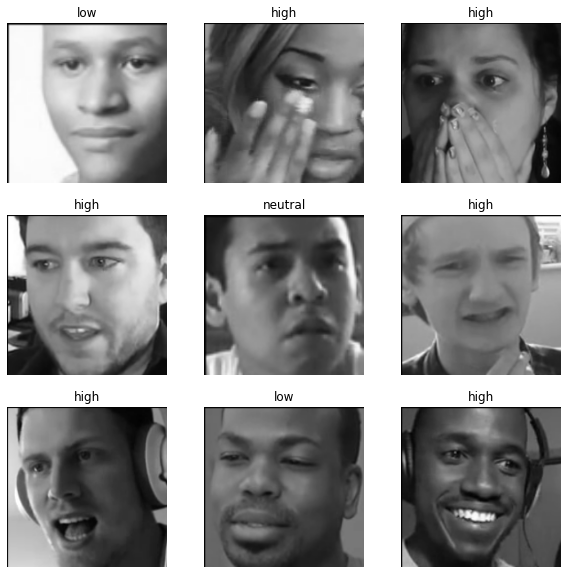

In [3]:
class_names = train_ds.class_names
print(class_names)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [5]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [6]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3)
])

In [7]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1
)

1813/7468 [======>.......................] - ETA: 11:35 - loss: 0.9756 - accuracy: 0.5017

InternalError: Could not synchronize CUDA stream: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered

In [29]:
#result = model.evaluate(test_ds)
#dict(zip(model.metrics_names, result))

test_images = []
test_labels = []

for image, label in test_ds:
  test_images.append(image.numpy())
  test_labels.append(label.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_images), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')



ResourceExhaustedError: Failed to allocate memory for the batch of component 0

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()